In [283]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests
import pathlib
import tspex

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [284]:
ASSAY_LIST_PATH = "assay-list-olink-explore-3072.xlsx"
BRAIN_RNA_SEQ_PATH = "brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
PLATE_LAYOUT_PATH = "Plate Layout.xlsx"
RAW_DATA_FILE = "LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"

In [285]:
assays = pd.read_excel(ASSAY_LIST_PATH)

# Map UniProt IDs to the corresponding FASTA sequences
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""
    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence
    return protein_dict

fasta_sequences = parse_gz_file(UNIPROT_TO_FASTA_PATH)

assays["Sequence"] = assays["UniProt ID"].map(
    lambda x: fasta_sequences.get(x, "N/A")
)

In [286]:
def tmhmm_localization(assays, output_directory):
    deeptmhmm = biolib.load("DTU/DeepTMHMM")
    with open("query.fasta", "w") as fasta_file:
        for _, row in assays.iterrows():
            fasta_line = f">{row['UniProt ID']}\n{row['Sequence']}\n"
            fasta_file.write(fasta_line)
        deeptmhmm_job = deeptmhmm.cli(
            args="--fasta query.fasta", machine="local"
        )
        deeptmhmm_job.save_files(output_directory)


def identify_localization(assays, region, output_directory = "olink_output"):
    """
    Parameters
    ----------
    assays : pandas.DataFrame
        DataFrame with columns called 'UniProt ID' and 'Sequence'
    region : {'TMhelix', 'inside', 'outside', 'internal'}
        Subcellular region requested. Options:
          - 'TMhelix': transmembrane proteins
          - 'inside': at least some of the protein is inside the cell/EV
          - 'outside': at least some of the protein is outside the cell/EV
          - 'internal': the protein is only found inside the cell, no transmembrane or outside domains
          - 'external': the protein is only found outside the cell, no transmembrane or inside domains
    """
    output_directory_path = pathlib.Path(output_directory)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    # os.chdir(output_directory)
    if not os.path.exists(output_directory_path / "TMRs.gff3"):
        tmhmm_localization(assays, output_directory_path)
    localization_df = pd.read_csv(output_directory_path / "TMRs.gff3", sep = "\t", comment = "#", names = ["uniprot_id", "region_location", "region_start", "region_end", 0, 1, 2, 3])
    localization_df = localization_df[localization_df["uniprot_id"] != "//"].dropna(axis = 1)
    get_regional_uniprots = lambda region: set(localization_df[localization_df["region_location"] == region]["uniprot_id"])
    if region == "internal":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return (inside_uniprots - tm_uniprots - outside_uniprots)
    if region == "external":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return (outside_uniprots - inside_uniprots - tm_uniprots)
    else: 
         return get_regional_uniprots(region)


tm_targets = identify_localization(assays, "TMhelix")
internal_targets = identify_localization(assays, "internal")
external_targets = identify_localization(assays, "external")

In [287]:
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)

hgnc_uniprot_mapping_data = pd.read_csv((StringIO(requests.get(HGNC_IDS).text)), sep = "\t", usecols = ["hgnc_id", "uniprot_ids"])
brain_rna_seq = pd.merge(brain_rna_seq, hgnc_uniprot_mapping_data, left_on = "id", right_on = "hgnc_id", how = "inner")
brain_rna_seq.dropna(subset=["uniprot_ids"], inplace=True)
brain_rna_seq.drop_duplicates(subset=['uniprot_ids'], inplace = True)

In [412]:
def calculate_mean(df):
    return df.assign(Mean=df.mean(axis=1, numeric_only=True))

def mean_cell_type(brain_rna_seq_data, cell_type):
    """
    Returns only the mean of the data for the specified cell type, as well as the UniProt ID information in an additional column
    Parameters
    ----------
    brain_rna_seq_data : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data
    cell_type : {'fetal', 'mature', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options: 
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    """
    if cell_type == "microglia":
        microglia_df = calculate_mean(brain_rna_seq_data[brain_rna_seq_data.filter(like='microglla').columns.append(pd.Index(["uniprot_ids"]))])[["uniprot_ids", "Mean"]]
        return microglia_df.rename(columns = {"uniprot_ids": "uniprot_ids", "Mean": "microglia"})
    if cell_type == "astrocyte":
        astrocyte_df = calculate_mean(brain_rna_seq_data[brain_rna_seq_data.filter(like='mature').columns.append(pd.Index(["uniprot_ids"]))])[["uniprot_ids", "Mean"]]
        return astrocyte_df.rename(columns = {"uniprot_ids": "uniprot_ids", "Mean": "astrocyte"})
    else:
        cell_type_df = calculate_mean(brain_rna_seq_data[brain_rna_seq_data.filter(like = cell_type).columns.append(pd.Index(["uniprot_ids"]))])[["uniprot_ids", "Mean"]]
        return cell_type_df.rename(columns = {"uniprot_ids": "uniprot_ids", "Mean": cell_type})

def cell_type_enrichment(brain_rna_seq_data, cell_type, indiv_specificity_metric, indiv_specificity_cutoff, general_specificity_metric = 'none', general_specificity_cutoff = 'none'):
    """
    Parameters
    ----------
    brain_rna_seq_data : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data for the cell types listed under cell_type
    cell_type : {'fetal', 'mature', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options: 
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    general_specificity_metric : {
        'tau', 
        'counts', 
        'gini', 
        'simpson', 
        'shannon_specifity', 
        'roku_specificity', 
        'spm_dpm', 
        'js_specificity_dpm', 
    }
        Primary metric of determining cell-type specificity requested. Options:
        - 'tau': tau score
        - 'counts': counts
        - 'gini': gini coefficient
        - 'simpson': simpson index
        - 'shannon_specificity': shannon entropy specificity (HS)
        - 'roku_specificity': ROKU specificity
        - 'spm_dpm': specificity measure dispersion (SPM DPM)
        - 'js_specificity_dpm': jensen-shannon specificity dispersion (JSS DPM)
        - 'none': default, no general specificity metric requested
    indiv_specificity_metric: {
        'tsi',
        'zscore', 
        'spm',
        'js_specificity'
    }
        Secondary metric of determining cell type specificity requested. Options:
        - 'tsi': tissue specificity index
        - 'z-score': z-score
        - 'spm': specificity measure
        - 'js_specificity': jensen-shannon specificity
    general_specificity_cutoff : numeric
        Numeric value representing the minimum value of the first enrichment cutoff.
        Default = none
    indiv_specificity_cutoff : numeric
        Numeric value representing the minimum value of the second enrichment cutoff.
    """
    astrocytes = mean_cell_type(brain_rna_seq, "astrocyte")
    endothelial = mean_cell_type(brain_rna_seq, "endothelial")
    microglia = mean_cell_type(brain_rna_seq, "microglia")
    oligodendrocytes = mean_cell_type(brain_rna_seq, "oligodendrocyte")
    neurons = mean_cell_type(brain_rna_seq, "neuron")

    all_cell_types = pd.merge(pd.merge(pd.merge(pd.merge(astrocytes, endothelial, on = "uniprot_ids"), microglia, on = "uniprot_ids"), oligodendrocytes, on = "uniprot_ids"), neurons, on = "uniprot_ids")
    all_cell_types.set_index("uniprot_ids", inplace = True)

    expression_data = all_cell_types.loc[:, ["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"]]
    expression_data = expression_data.loc[(expression_data > 0).any(axis=1)]


    if general_specificity_metric == "none":
        tso_indiv = tspex.TissueSpecificity(expression_data, indiv_specificity_metric, log = True)
    else:
        tso_gen = tspex.TissueSpecificity(expression_data, general_specificity_metric, log = True)
        tso_gen_df = pd.DataFrame(tso_gen.tissue_specificity, columns = ["general_specificity_metric"])
        tso_gen_filtered = list(tso_gen_df[tso_gen_df["general_specificity_metric"] > general_specificity_cutoff].index)
        tso_gen_filtered_df = expression_data.loc[tso_gen_filtered]

        tso_indiv = tspex.TissueSpecificity(tso_gen_filtered_df, indiv_specificity_metric, log = True)
        

    tso_indiv_df = pd.DataFrame(tso_indiv.tissue_specificity, columns = ["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"])
    cell_type_uniprot_ids = tso_indiv_df[tso_indiv_df[cell_type] > indiv_specificity_cutoff].index.tolist()
    return cell_type_uniprot_ids

astrocyte_uniprot_ids = cell_type_enrichment(brain_rna_seq, "astrocyte", "zscore", 0.45, "tau", 0.7)

In [299]:
UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]

PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]

# Clean up the raw OLINK data file and map the sample locations to their barcodes
plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

data = pd.merge(raw_data, plate_layout, how="left", on="SampleID")

# Normalize the data according to plate negative controls
ctrl_dict = {}
for panel in PANELS:
    df = data[(data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["NPX"].median()
    ctrl_dict[panel] = plate_ctrl
data["Delta"] = data.apply(
    lambda row: row["NPX"] - ctrl_dict[row["Panel"]],
    axis=1,
)

# Linearize the NPX values
data["Linear Delta"] = data["Delta"].map(lambda x: 2**x)

# Identify and drop replicate assays
vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]

unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
uniprot_list = unique_uniprot_values.tolist()

raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()

# Create a tidy dataframe for the delta values
tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
    columns="UniProt", index=["SampleID", "Health", "Sample"], values="Linear Delta"
)

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_1976\2731001649.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_healthy_mannwhitneyu = pd.concat(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_1976\2731001649.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_mci_mannwhitneyu = pd.concat(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_1976\2731001649.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this 

Text(0.5, 1.0, 'Assays with Significant Differences Between Samples')

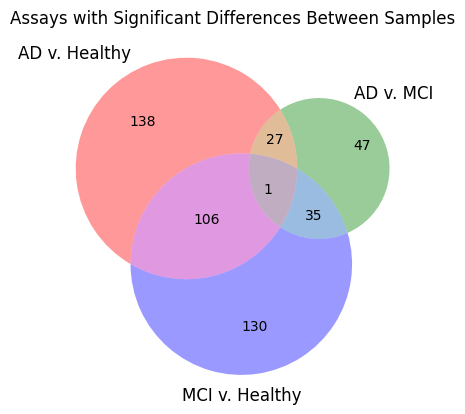

In [300]:
# Mann-Whitney U Test to determine significant difference between AD/MCI/Healthy samples in all fractions

assay_list = list(tidy_data.columns)

healthy_df = tidy_data[tidy_data.index.get_level_values("Health") == "Healthy"]
mci_df = tidy_data[tidy_data.index.get_level_values("Health") == "MCI"]
ad_df = tidy_data[tidy_data.index.get_level_values("Health") == "AD"]

ad_healthy_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

for assay in assay_list:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])

    ad_healthy_statistic, ad_healthy_p_value = mannwhitneyu(ad_assays, healthy_assays)
    ad_mci_statistic, ad_mci_p_value = mannwhitneyu(ad_assays, mci_assays)
    mci_healthy_statistic, mci_healthy_p_value = mannwhitneyu(
        mci_assays, healthy_assays
    )

    ad_healthy_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [ad_healthy_p_value],
            "Statistic": [ad_healthy_statistic],
        }
    )
    ad_mci_result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [ad_mci_p_value], "Statistic": [ad_mci_statistic]}
    )
    mci_healthy_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [mci_healthy_p_value],
            "Statistic": [mci_healthy_statistic],
        }
    )

    ad_healthy_mannwhitneyu = pd.concat(
        [ad_healthy_mannwhitneyu, ad_healthy_result_row], ignore_index=True
    )
    ad_mci_mannwhitneyu = pd.concat(
        [ad_mci_mannwhitneyu, ad_mci_result_row], ignore_index=True
    )
    mci_healthy_mannwhitneyu = pd.concat(
        [mci_healthy_mannwhitneyu, mci_healthy_result_row], ignore_index=True
    )

ad_healthy_sig_dif = ad_healthy_mannwhitneyu[ad_healthy_mannwhitneyu["p-value"] < 0.05]
ad_mci_sig_dif = ad_mci_mannwhitneyu[ad_mci_mannwhitneyu["p-value"] < 0.05]
mci_healthy_sig_dif = mci_healthy_mannwhitneyu[
    mci_healthy_mannwhitneyu["p-value"] < 0.05
]

ad_healthy_sig_dif_assays = set(ad_healthy_sig_dif["Assay"])
ad_mci_sig_dif_assays = set(ad_mci_sig_dif["Assay"])
mci_healthy_sig_dif_assays = set(mci_healthy_sig_dif["Assay"])

venn3(
    [ad_healthy_sig_dif_assays, ad_mci_sig_dif_assays, mci_healthy_sig_dif_assays],
    set_labels=("AD v. Healthy", "AD v. MCI", "MCI v. Healthy"),
)
plt.title("Assays with Significant Differences Between Samples")

In [301]:
# Mann-Whitney U Test to determine significant difference between AD/MCI/Healthy samples in EV/secreted fractions

assay_list = list(tidy_data.columns)

ad_healthy_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

ad_healthy_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

for assay in assay_list:
    tidy_data_assay = tidy_data[assay]
    if not tidy_data_assay.isna().all():
        healthy_assay_ev_peak = (
            (tidy_data_assay.index.get_level_values("Sample").str.contains("9"))
            | (tidy_data_assay.index.get_level_values("Sample").str.contains("10"))
            ) & (tidy_data_assay.index.get_level_values("Health") == "Healthy")
        mci_assay_ev_peak = (
            (tidy_data_assay.index.get_level_values("Sample").str.contains("9"))
            | (tidy_data_assay.index.get_level_values("Sample").str.contains("10"))
        ) & (tidy_data_assay.index.get_level_values("Health") == "Healthy")
        mci_assay_ev_peak = (
            (tidy_data_assay.index.get_level_values("Sample").str.contains("9"))
            | (tidy_data_assay.index.get_level_values("Sample").str.contains("10"))
        ) & (tidy_data_assay.index.get_level_values("Health") == "MCI")
        ad_assay_ev_peak = (
            (tidy_data_assay.index.get_level_values("Sample").str.contains("9"))
            | (tidy_data_assay.index.get_level_values("Sample").str.contains("10"))
        ) & (tidy_data_assay.index.get_level_values("Health") == "AD")
        healthy_assay_ev_values = tidy_data_assay.loc[healthy_assay_ev_peak].values
        mci_assay_ev_values = tidy_data_assay.loc[mci_assay_ev_peak].values
        ad_assay_ev_values = tidy_data_assay.loc[ad_assay_ev_peak].values
        if not (np.all(np.isnan(healthy_assay_ev_peak))) or not (np.all(np.isnan(mci_assay_ev_peak))) or not (np.all(np.isnan(ad_assay_ev_peak))):
            ad_healthy_ev_statistic, ad_healthy_ev_p_value = mannwhitneyu(
                ad_assay_ev_values, healthy_assay_ev_values
            )
            ad_mci_ev_statistic, ad_mci_ev_p_value = mannwhitneyu(
                ad_assay_ev_values, mci_assay_ev_values
            )
            mci_healthy_ev_statistic, mci_healthy_ev_p_value = mannwhitneyu(
                mci_assay_ev_values, healthy_assay_ev_values
            )
            ad_healthy_ev_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [ad_healthy_ev_p_value],
                    "Statistic": [ad_healthy_ev_statistic],
                }
            )
            ad_mci_ev_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [ad_mci_ev_p_value],
                    "Statistic": [ad_mci_ev_statistic],
                }
            )
            mci_healthy_ev_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [mci_healthy_ev_p_value],
                    "Statistic": [mci_healthy_ev_statistic],
                }
            )
            ad_healthy_ev_mannwhitneyu = pd.concat(
                [ad_healthy_ev_mannwhitneyu, ad_healthy_ev_result_row], ignore_index=True
            )
            ad_mci_ev_mannwhitneyu = pd.concat(
                [ad_mci_ev_mannwhitneyu, ad_mci_ev_result_row], ignore_index=True
            )
            mci_healthy_ev_mannwhitneyu = pd.concat(
                [mci_healthy_ev_mannwhitneyu, mci_healthy_ev_result_row], ignore_index=True
            )
        healthy_assay_secreted = (
            (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
            | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
        ) & (tidy_data_assay.index.get_level_values("Health") == "Healthy")
        mci_assay_secreted = (
            (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
            | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
        ) & (tidy_data_assay.index.get_level_values("Health") == "MCI")
        ad_assay_secreted = (
            (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
            | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
        ) & (tidy_data_assay.index.get_level_values("Health") == "AD")
        healthy_assay_secreted_values = tidy_data_assay.loc[healthy_assay_secreted].values
        mci_assay_secreted_values = tidy_data_assay.loc[mci_assay_secreted].values
        ad_assay_secreted_values = tidy_data_assay.loc[ad_assay_secreted].values
        if not (np.all(np.isnan(healthy_assay_secreted_values))) or not (np.all(np.isnan(mci_assay_secreted_values))) or not (np.all(np.isnan(ad_assay_secreted_values))):

            ad_healthy_secreted_statistic, ad_healthy_secreted_p_value = mannwhitneyu(
                ad_assay_secreted_values, healthy_assay_secreted_values
            )
            ad_mci_secreted_statistic, ad_mci_secreted_p_value = mannwhitneyu(
                ad_assay_secreted_values, mci_assay_secreted_values
            )
            mci_healthy_secreted_statistic, mci_healthy_secreted_p_value = mannwhitneyu(
                mci_assay_secreted_values, healthy_assay_secreted_values
            )
            ad_healthy_secreted_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [ad_healthy_secreted_p_value],
                    "Statistic": [ad_healthy_secreted_statistic],
                }
            )
            ad_mci_secreted_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [ad_mci_secreted_p_value],
                    "Statistic": [ad_mci_secreted_statistic],
                }
            )
            mci_healthy_secreted_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [mci_healthy_secreted_p_value],
                    "Statistic": [mci_healthy_secreted_statistic],
                }
            )
            ad_healthy_secreted_mannwhitneyu = pd.concat(
                [ad_healthy_secreted_mannwhitneyu, ad_healthy_secreted_result_row],
                ignore_index=True,
            )
            ad_mci_secreted_mannwhitneyu = pd.concat(
                [ad_mci_secreted_mannwhitneyu, ad_mci_secreted_result_row], ignore_index=True
            )
            mci_healthy_secreted_mannwhitneyu = pd.concat(
                [mci_healthy_secreted_mannwhitneyu, mci_healthy_secreted_result_row],
                ignore_index=True,
            )

    ad_healthy_ev_sig_dif = ad_healthy_ev_mannwhitneyu[
        ad_healthy_ev_mannwhitneyu["p-value"] < 0.05
    ]
    ad_mci_ev_sig_dif = ad_mci_ev_mannwhitneyu[ad_mci_ev_mannwhitneyu["p-value"] < 0.05]
    mci_healthy_ev_sig_dif = mci_healthy_ev_mannwhitneyu[
        mci_healthy_ev_mannwhitneyu["p-value"] < 0.05
    ]

    ad_healthy_secreted_sig_dif = ad_healthy_secreted_mannwhitneyu[
        ad_healthy_secreted_mannwhitneyu["p-value"] < 0.05
    ]
    ad_mci_secreted_sig_dif = ad_mci_secreted_mannwhitneyu[
        ad_mci_secreted_mannwhitneyu["p-value"] < 0.05
    ]
    mci_healthy_secreted_sig_dif = mci_healthy_secreted_mannwhitneyu[
        mci_healthy_secreted_mannwhitneyu["p-value"] < 0.05
    ]

ad_healthy_ev_sig_dif_assays = set(ad_healthy_ev_sig_dif["Assay"])
ad_mci_ev_sig_dif_assays = set(ad_mci_ev_sig_dif["Assay"])
mci_healthy_ev_sig_dif_assays = set(mci_healthy_ev_sig_dif["Assay"])

ad_healthy_secreted_sig_dif_assays = set(ad_healthy_secreted_sig_dif["Assay"])
ad_mci_secreted_sig_dif_assays = set(ad_mci_secreted_sig_dif["Assay"])
mci_healthy_secreted_sig_dif_assays = set(mci_healthy_secreted_sig_dif["Assay"])

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_1976\2880544966.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_healthy_ev_mannwhitneyu = pd.concat(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_1976\2880544966.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_mci_ev_mannwhitneyu = pd.concat(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_1976\2880544966.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version,

Text(0.5, 1.0, 'Assays with Significant Differences in EV Fractions')

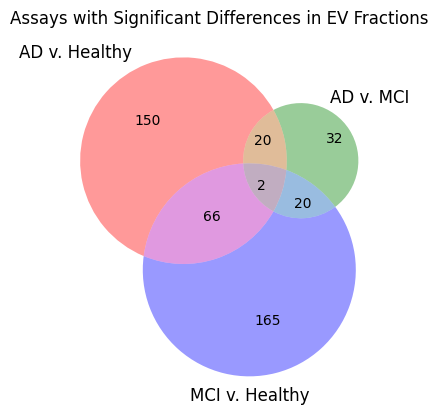

In [302]:
# Make a venn diagram of assays with significant differences in the EV fractions between sample groups
venn3(
    [
        ad_healthy_ev_sig_dif_assays,
        ad_mci_ev_sig_dif_assays,
        mci_healthy_ev_sig_dif_assays,
    ],
    set_labels=("AD v. Healthy", "AD v. MCI", "MCI v. Healthy"),
)
plt.title("Assays with Significant Differences in EV Fractions")

Text(0.5, 1.0, 'Assays with Significant Differences in Secreted Fractions')

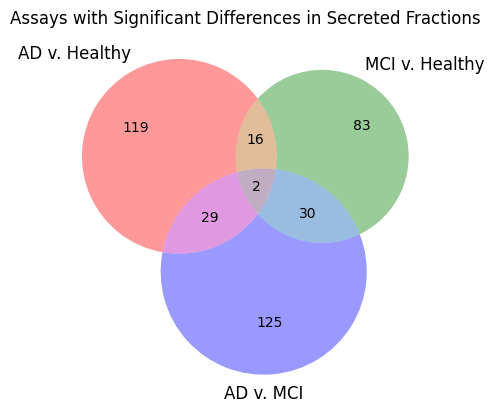

In [303]:
# Make a venn diagram of assays with significant differences in the secreted fractions between sample groups
venn3(
    [
        ad_healthy_secreted_sig_dif_assays,
        mci_healthy_secreted_sig_dif_assays,
        ad_mci_secreted_sig_dif_assays,
    ],
    set_labels=("AD v. Healthy", "MCI v. Healthy", "AD v. MCI"),
)
plt.title("Assays with Significant Differences in Secreted Fractions")

Text(0.5, 1.0, 'Assays with Significant Differences Between Sample Groups')

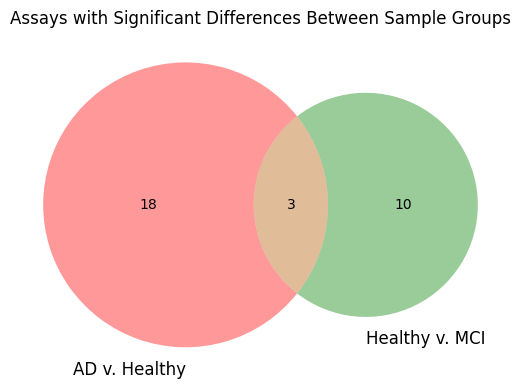

In [304]:
# Make a venn diagram of assays that have a significant difference between the sample groups
venn2(
    [
        (ad_healthy_ev_sig_dif_assays & ad_healthy_secreted_sig_dif_assays),
        (mci_healthy_ev_sig_dif_assays & mci_healthy_secreted_sig_dif_assays),
    ],
    set_labels=("AD v. Healthy", "Healthy v. MCI"),
)
plt.title("Assays with Significant Differences Between Sample Groups")

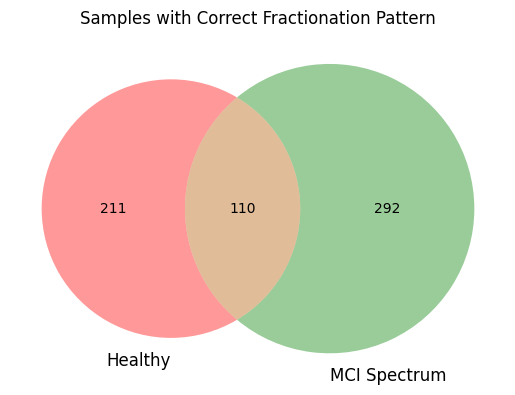

In [305]:
# Fractionation analysis comparison of healthy vs. MCI spectrum samples
healthy_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract6 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 6 ")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract11 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract12 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract13 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

mci_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (tidy_data.index.get_level_values("Health") == "MCI")
]

mci_fract6 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 6 ")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract11 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract12 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract13 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]


healthy_fractionation = []
mci_fractionation = []


for assay in list(tidy_data.columns):
    if not tidy_data[assay].isna().all():
        healthy_ev_fraction_median = healthy_ev_fractions[assay].median()
        healthy_fract6_median = healthy_fract6[assay].median()
        healthy_fract11_median = healthy_fract11[assay].median()
        healthy_fract12_median = healthy_fract12[assay].median()
        healthy_fract13_median = healthy_fract13[assay].median()
        if (
            (healthy_ev_fraction_median > healthy_fract6_median)
            and (healthy_ev_fraction_median > healthy_fract11_median)
            and (healthy_ev_fraction_median > healthy_fract12_median)
            and (healthy_ev_fraction_median > healthy_fract13_median)
        ):
            healthy_fractionation.append(assay)
        mci_ev_fraction_median = mci_ev_fractions[assay].median()
        mci_fract6_median = mci_fract6[assay].median()
        mci_fract11_median = mci_fract11[assay].median()
        mci_fract12_median = mci_fract12[assay].median()
        mci_fract13_median = mci_fract13[assay].median()
        if (
            (mci_ev_fraction_median > mci_fract6_median)
            and (mci_ev_fraction_median > mci_fract11_median)
            and (mci_ev_fraction_median > mci_fract12_median)
            and (mci_ev_fraction_median > mci_fract13_median)
        ):
            mci_fractionation.append(assay)

venn2(
    [set(healthy_fractionation), set(mci_fractionation)],
    set_labels=("Healthy", "MCI Spectrum"),
)
plt.title("Samples with Correct Fractionation Pattern")
plt.show()

In [306]:
# All samples fractionation analysis
ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]
fract6 = tidy_data[(tidy_data.index.get_level_values("Sample").str.contains("6"))]
fract11 = tidy_data[(tidy_data.index.get_level_values("Sample").str.contains("11"))]
fract12 = tidy_data[(tidy_data.index.get_level_values("Sample").str.contains("12"))]
fract13 = tidy_data[(tidy_data.index.get_level_values("Sample").str.contains("13"))]

correct_fractionation = []
annoying_assays = []

for assay in list(tidy_data.columns):
    if not tidy_data[assay].isna().all():
        ev_fraction_median = ev_fractions[assay].median()
        fract6_median = fract6[assay].median()
        fract11_median = fract11[assay].median()
        fract12_median = fract12[assay].median()
        fract13_median = fract13[assay].median()
        if (
            (ev_fraction_median > fract6_median)
            and (ev_fraction_median > fract11_median)
            and (ev_fraction_median > fract12_median)
            and (ev_fraction_median > fract13_median)
        ):
            correct_fractionation.append(assay)
    else: 
        annoying_assays.append(assay)

In [307]:
len(annoying_assays)

40

In [395]:
# Overlap between median assays, brain rna seq, and internal only tmhmm

# Internal microglia
internal_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprot_ids) & set(internal_targets)
)

# Internal astrocyte
internal_astrocyte_targets = (
    set(correct_fractionation) & set(astrocyte_uniprot_ids) & set(internal_targets)
)

# Internal oligodendrocyte
internal_oligodendrocyte_targets = (
    set(correct_fractionation) & set(oligodendrocyte_uniprot_ids) & set(internal_targets)
)

# Internal neuron
internal_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprot_ids) & set(internal_targets)
)

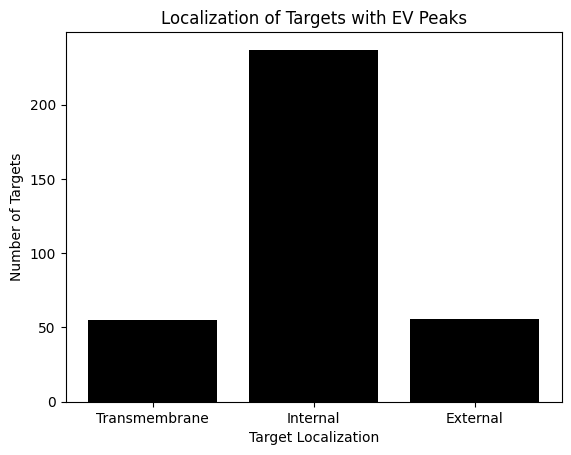

In [310]:
tm_peak = set(tm_targets) & set(correct_fractionation)
internal_peak = set(internal_targets) & set(correct_fractionation)
external_peak = set(external_targets) & set(correct_fractionation)

peak_dict = {
    "Transmembrane": len(tm_peak),
    "Internal": len(internal_peak),
    "External": len(external_peak),
}

x_labels = list(peak_dict.keys())
y_labels = list(peak_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Target Localization")
plt.ylabel("Number of Targets")
plt.title("Localization of Targets with EV Peaks")
plt.show()

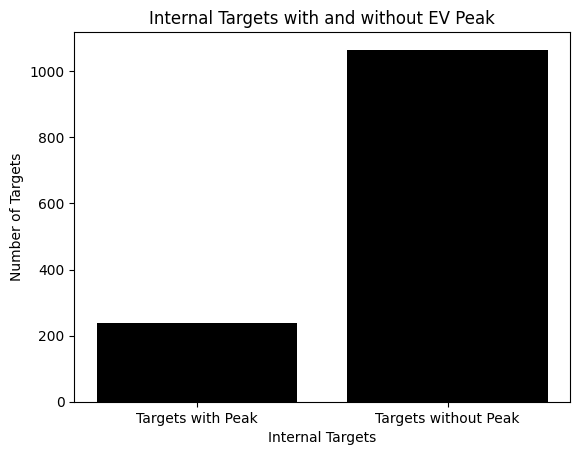

In [312]:
internal_with_peak = set(internal_targets) & set(correct_fractionation)
internal_without_peak = set(internal_targets) - set(correct_fractionation)

int_dict = {
    "Targets with Peak": len(internal_with_peak),
    "Targets without Peak": len(internal_without_peak),
}

x_labels = list(int_dict.keys())
y_labels = list(int_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Internal Targets")
plt.ylabel("Number of Targets")
plt.title("Internal Targets with and without EV Peak")
plt.show()

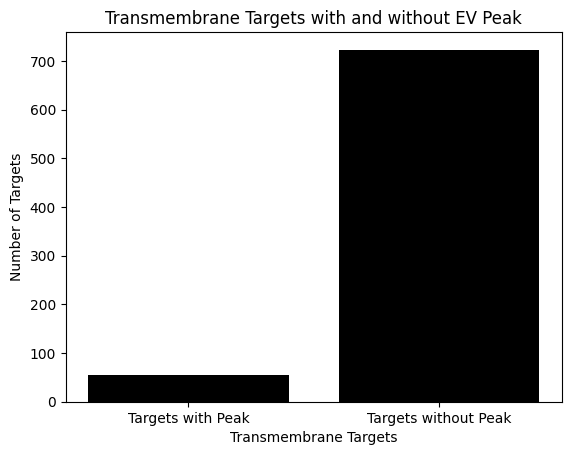

In [313]:
tm_with_peak = set(tm_targets) & set(correct_fractionation)
tm_without_peak = set(tm_targets) - set(correct_fractionation)

tm_dict = {
    "Targets with Peak": len(tm_with_peak),
    "Targets without Peak": len(tm_without_peak),
}

x_labels = list(tm_dict.keys())
y_labels = list(tm_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Transmembrane Targets")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets with and without EV Peak")
plt.show()

In [393]:
# Overlap between median assays, brain rna seq, and transmembrane targets

# TM microglia
tm_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprot_ids) & set(tm_targets)
)

# TM astrocyte
tm_astrocyte_targets = (
    set(correct_fractionation) & set(astrocyte_uniprot_ids) & set(tm_targets)
)

# TM oligodendrocyte
tm_oligodendrocyte_targets = (
    set(correct_fractionation) & set(oligodendrocyte_uniprot_ids) & set(tm_targets)
)

# TM neuron
tm_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprot_ids) & set(tm_targets)
)

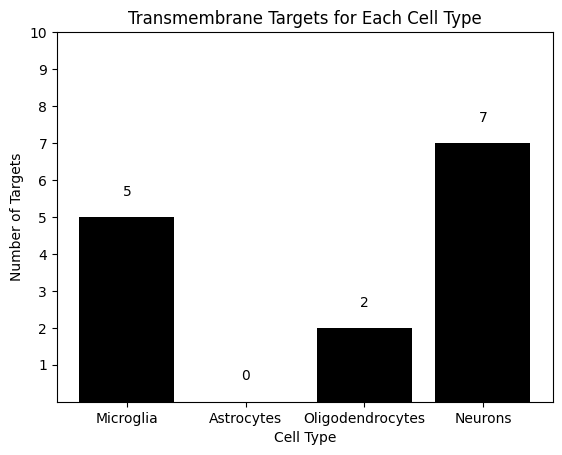

In [394]:
# Number of transmembrane targets per cell type

internal_dict = {
    "Microglia": len(tm_microglia_targets),
    "Astrocytes": len(tm_astrocyte_targets),
    "Oligodendrocytes": len(tm_oligodendrocyte_targets),
    "Neurons": len(tm_neuron_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets for Each Cell Type")
plt.show()

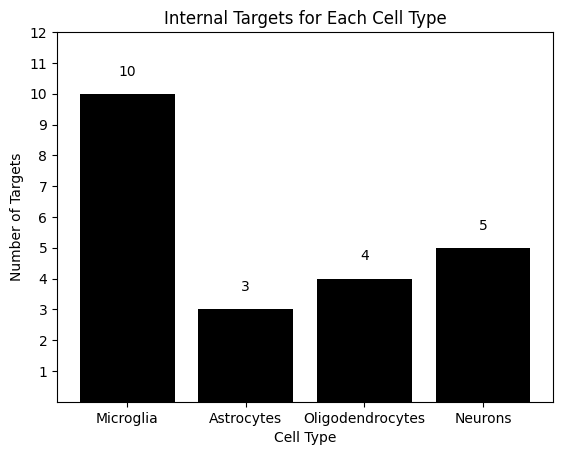

In [396]:
internal_dict = {
    "Microglia": len(internal_microglia_targets),
    "Astrocytes": len(internal_astrocyte_targets),
    "Oligodendrocytes": len(internal_oligodendrocyte_targets),
    "Neurons": len(internal_neuron_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Internal Targets for Each Cell Type")
plt.show()

In [ ]:
CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
]

def graph_medians(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"{uniprot_id} Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()